# Texture Coefficient Analysis
## XRD Data Analysis: Reference vs Experimental

This notebook analyzes texture coefficients by comparing experimental X-ray diffraction (XRD) data with JCPDS-ICDD reference crystallographic data.

**Texture Coefficient (TC)**: A quantitative measure of crystal preferred orientation, calculated as the ratio of observed peak intensity to the reference intensity for each crystallographic plane.

## 1. Load Reference Data from JCPDS-ICDD

Reference crystallographic data is loaded from the JCPDS-ICDD folder. This data includes standard peak positions (2θ angles) and relative intensities for the crystal structure.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Define base paths
data_folder = 'data'
reference_folder = 'JCPDS-ICDD'

# Reference crystallographic database (from JCPDS-15-0861)
# This contains standard peak intensities and 2-theta angles
reference_data = {
    '110': {'2theta': 10.676, 'I0': 8.0},
    '020': {'2theta': 15.029, 'I0': 25.0},
    '200': {'2theta': 15.211, 'I0': 6.0},
    '120': {'2theta': 16.874, 'I0': 55.0},
    '220': {'2theta': 21.446, 'I0': 10.0},
    '101': {'2theta': 23.643, 'I0': 12.0},
    '130': {'2theta': 23.901, 'I0': 30.0},
    '310': {'2theta': 24.152, 'I0': 16.0},
    '021': {'2theta': 27.023, 'I0': 12.0},
    '230': {'2theta': 27.395, 'I0': 70.0},
    '211': {'2theta': 28.2, 'I0': 75.0},
    '040': {'2theta': 30.326, 'I0': 2.0},
    '400': {'2theta': 30.699, 'I0': 4.0},
    '221': {'2theta': 31.16, 'I0': 100.0},
    '301': {'2theta': 32.22, 'I0': 60.0},
    '330': {'2theta': 32.424, 'I0': 10.0},
    '311': {'2theta': 33.115, 'I0': 20.0},
    '240': {'2theta': 34.075, 'I0': 60.0},
    '420': {'2theta': 34.358, 'I0': 20.0},
    '321': {'2theta': 35.7, 'I0': 30.0},
    '041': {'2theta': 37.984, 'I0': 25.0},
    '340': {'2theta': 38.354, 'I0': 14.0},
    '430': {'2theta': 38.49, 'I0': 14.0},
    '141': {'2theta': 38.801, 'I0': 35.0},
    '411': {'2theta': 39.081, 'I0': 12.0},
    '510': {'2theta': 39.456, 'I0': 8.0},
    '331': {'2theta': 39.71, 'I0': 8.0},
    '250': {'2theta': 41.305, 'I0': 35.0},
    '520': {'2theta': 41.705, 'I0': 20.0},
    '440': {'2theta': 43.694, 'I0': 10.0},
    '431': {'2theta': 44.95, 'I0': 35.0},
    '501': {'2theta': 45.068, 'I0': 30.0},
    '530': {'2theta': 45.258, 'I0': 30.0},
    '151': {'2theta': 45.354, 'I0': 25.0},
    '002': {'2theta': 45.571, 'I0': 25.0},
    '060': {'2theta': 46.209, 'I0': 8.0},
    '600': {'2theta': 46.84, 'I0': 8.0},
    '160': {'2theta': 46.892, 'I0': 8.0},
    '610': {'2theta': 47.49, 'I0': 8.0},
    '212': {'2theta': 48.902, 'I0': 8.0},
    '620': {'2theta': 49.469, 'I0': 4.0},
    '441': {'2theta': 49.584, 'I0': 4.0},
    '540': {'2theta': 49.903, 'I0': 4.0},
    '351': {'2theta': 50.765, 'I0': 8.0},
    '531': {'2theta': 51.039, 'I0': 16.0},
    '061': {'2theta': 51.879, 'I0': 45.0},
    '360': {'2theta': 52.166, 'I0': 20.0},
    '322': {'2theta': 53.956, 'I0': 14.0},
    '621': {'2theta': 54.865, 'I0': 6.0},
    '710': {'2theta': 55.807, 'I0': 6.0},
    '142': {'2theta': 56.328, 'I0': 1.0},
    '412': {'2theta': 56.479, 'I0': 1.0},
    '640': {'2theta': 56.821, 'I0': 6.0},
    '270': {'2theta': 56.898, 'I0': 8.0},
    '720': {'2theta': 57.559, 'I0': 12.0},
    '242': {'2theta': 58.115, 'I0': 18.0},
    '422': {'2theta': 58.276, 'I0': 10.0},
    '370': {'2theta': 59.854, 'I0': 8.0},
    '171': {'2theta': 60.155, 'I0': 6.0},
}

# Create DataFrame from reference data
reference_df = pd.DataFrame(reference_data).T
reference_df['hkl'] = reference_df.index
print("Reference Data Loaded:")
print(reference_df.head(10))

Reference Data Loaded:
     2theta    I0  hkl
110  10.676   8.0  110
020  15.029  25.0  020
200  15.211   6.0  200
120  16.874  55.0  120
220  21.446  10.0  220
101  23.643  12.0  101
130  23.901  30.0  130
310  24.152  16.0  310
021  27.023  12.0  021
230  27.395  70.0  230


## 2. Load Experimental Data

Load experimental XRD data from the `data` folder. The data files are in XRDML format (.xrdml), which contains 2θ angles and intensity measurements.

In [31]:
def parse_xrdml(filepath):
    """
    Parse XRDML file and extract 2-theta angles and intensities.
    Returns DataFrame with columns: '2theta', 'intensity'
    """
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        
        # Define namespace for XRDML (PANalytical format)
        ns = {'xrdml': 'http://www.xrdml.com/XRDMeasurement/1.5'}
        
        # Get start position and step size
        positions = root.findall('.//xrdml:dataPoints/xrdml:positions[@axis="2Theta"]', ns)
        if not positions:
            print(f"Warning: No 2Theta positions found in {filepath}")
            return pd.DataFrame()
        
        start_pos = float(positions[0].find('xrdml:startPosition', ns).text)
        
        # Get intensities data
        intensities_elem = root.find('.//xrdml:intensities', ns)
        if intensities_elem is None:
            print(f"Warning: No intensities data found in {filepath}")
            return pd.DataFrame()
        
        # Parse intensities
        intensities_text = intensities_elem.text.strip()
        intensities = np.array([float(x) for x in intensities_text.split()])
        
        # Get the scan range to determine step size
        common_positions = root.find('.//xrdml:dataPoints/xrdml:positions[@axis="2Theta"]/xrdml:commonPosition', ns)
        if common_positions is not None:
            # Fixed step size scan
            step = float(common_positions.get('step', 0.02))
        else:
            # Variable step size - calculate from positions
            end_pos = float(positions[0].find('xrdml:endPosition', ns).text)
            step = (end_pos - start_pos) / (len(intensities) - 1) if len(intensities) > 1 else 0.02
        
        # Generate 2-theta array
        two_theta = np.arange(start_pos, start_pos + len(intensities) * step, step)
        
        # Trim to match intensities length
        two_theta = two_theta[:len(intensities)]
        
        return pd.DataFrame({
            '2theta': two_theta,
            'intensity': intensities
        })
        
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Load all XRDML files from data folder
xrdml_files = list(Path(data_folder).glob('*.xrdml'))
print(f"Found {len(xrdml_files)} XRDML files:")
for f in xrdml_files:
    print(f"  - {f.name}")

# Parse all experimental data files
experimental_data = {}
for xrdml_file in xrdml_files:
    filename = xrdml_file.name.replace('.xrdml', '')
    exp_df = parse_xrdml(str(xrdml_file))
    if not exp_df.empty:
        experimental_data[filename] = exp_df
        print(f"\nLoaded {filename}: {len(exp_df)} data points")
        print(f"  2θ range: {exp_df['2theta'].min():.2f}° - {exp_df['2theta'].max():.2f}°")
        print(f"  Intensity range: {exp_df['intensity'].min():.2f} - {exp_df['intensity'].max():.2f}")
    else:
        print(f"\n{filename}: FAILED TO LOAD")

# Display summary
if experimental_data:
    print(f"\nSuccessfully loaded {len(experimental_data)} experimental dataset(s)")
else:
    print("\nERROR: No experimental datasets were loaded!")

Found 2 XRDML files:
  - Training_BraggBrentano_1hr_1.xrdml
  - Training_BraggBrentano_Fast.xrdml

Loaded Training_BraggBrentano_1hr_1: 16247 data points
  2θ range: 10.00° - 90.00°
  Intensity range: 509.00 - 97667.00

Loaded Training_BraggBrentano_Fast: 16100 data points
  2θ range: 10.00° - 89.27°
  Intensity range: 65.00 - 16661.00

Successfully loaded 2 experimental dataset(s)


## 3. Parse and Compare Peak Intensities

Match experimental peaks with reference peaks using the 2θ angles and normalize intensities for comparison.

In [32]:
def find_peak_intensity(df, target_2theta, tolerance=0.5):
    """
    Find peak intensity near a target 2-theta angle within tolerance.
    """
    mask = (df['2theta'] >= target_2theta - tolerance) & (df['2theta'] <= target_2theta + tolerance)
    if mask.any():
        peak_data = df[mask]
        # Return the intensity at the nearest 2-theta value
        nearest_idx = (peak_data['2theta'] - target_2theta).abs().idxmin()
        return df.loc[nearest_idx, 'intensity']
    return np.nan

def match_peaks(exp_df, reference_df, tolerance=0.5):
    """
    Match experimental peaks with reference peaks.
    Returns DataFrame with matched data.
    """
    matched_data = []
    
    for hkl, row in reference_df.iterrows():
        ref_2theta = row['2theta']
        ref_intensity = row['I0']
        
        exp_intensity = find_peak_intensity(exp_df, ref_2theta, tolerance)
        
        matched_data.append({
            'hkl': hkl,
            'ref_2theta': ref_2theta,
            'ref_intensity': ref_intensity,
            'exp_intensity': exp_intensity
        })
    
    return pd.DataFrame(matched_data).dropna(subset=['exp_intensity'])

# Match peaks for all experimental datasets
peak_matches = {}
for filename, exp_df in experimental_data.items():
    matched = match_peaks(exp_df, reference_df, tolerance=0.5)
    peak_matches[filename] = matched
    print(f"\n{filename}:")
    print(f"  Matched {len(matched)} peaks")
    print(matched.head(8))


Training_BraggBrentano_1hr_1:
  Matched 59 peaks
   hkl  ref_2theta  ref_intensity  exp_intensity
0  110      10.676            8.0        11178.0
1  020      15.029           25.0        14691.0
2  200      15.211            6.0        13868.0
3  120      16.874           55.0        11329.0
4  220      21.446           10.0         3816.0
5  101      23.643           12.0         4265.0
6  130      23.901           30.0         3784.0
7  310      24.152           16.0         3297.0

Training_BraggBrentano_Fast:
  Matched 59 peaks
   hkl  ref_2theta  ref_intensity  exp_intensity
0  110      10.676            8.0         1870.0
1  020      15.029           25.0         2546.0
2  200      15.211            6.0         2188.0
3  120      16.874           55.0         1827.0
4  220      21.446           10.0          690.0
5  101      23.643           12.0          761.0
6  130      23.901           30.0          639.0
7  310      24.152           16.0          534.0


## 4. Calculate Texture Coefficient

Compute the texture coefficient (TC) for each crystallographic plane:

$$TC = \frac{I_{observed}}{I_{reference}} \times \frac{1}{R}$$

where:
- $I_{observed}$ = observed intensity of the peak
- $I_{reference}$ = reference intensity from JCPDS data
- $R$ = average of all TC values (normalization factor)

In [33]:
def calculate_texture_coefficient(matched_df):
    """
    Calculate texture coefficient for matched peaks.
    TC = (I_observed / I_reference) / R
    where R is the mean of all I_observed / I_reference ratios.
    """
    # Calculate intensity ratios
    matched_df = matched_df.copy()
    matched_df['ratio'] = matched_df['exp_intensity'] / matched_df['ref_intensity']
    
    # Calculate normalization factor (mean ratio)
    R = matched_df['ratio'].mean()
    
    # Calculate texture coefficient
    matched_df['TC'] = matched_df['ratio'] / R
    
    return matched_df, R

# Calculate TC for all datasets
texture_coefficients = {}
normalization_factors = {}

for filename, matched_df in peak_matches.items():
    tc_df, R = calculate_texture_coefficient(matched_df)
    texture_coefficients[filename] = tc_df
    normalization_factors[filename] = R
    
    print(f"\n{filename}:")
    print(f"  Normalization Factor (R): {R:.4f}")
    print(f"  Number of matched peaks: {len(tc_df)}")
    print("\n  Texture Coefficients by plane:")
    print(tc_df[['hkl', 'exp_intensity', 'ref_intensity', 'ratio', 'TC']].to_string())
    print(f"\n  TC Statistics:")
    print(f"    Mean TC: {tc_df['TC'].mean():.4f}")
    print(f"    Std Dev: {tc_df['TC'].std():.4f}")
    print(f"    Min: {tc_df['TC'].min():.4f}, Max: {tc_df['TC'].max():.4f}")


Training_BraggBrentano_1hr_1:
  Normalization Factor (R): 267.8574
  Number of matched peaks: 59

  Texture Coefficients by plane:
    hkl  exp_intensity  ref_intensity        ratio        TC
0   110        11178.0            8.0  1397.250000  5.216394
1   020        14691.0           25.0   587.640000  2.193854
2   200        13868.0            6.0  2311.333333  8.628968
3   120        11329.0           55.0   205.981818  0.768998
4   220         3816.0           10.0   381.600000  1.424638
5   101         4265.0           12.0   355.416667  1.326887
6   130         3784.0           30.0   126.133333  0.470897
7   310         3297.0           16.0   206.062500  0.769299
8   021         3076.0           12.0   256.333333  0.956977
9   230         3521.0           70.0    50.300000  0.187786
10  211         8268.0           75.0   110.240000  0.411562
11  040         2298.0            2.0  1149.000000  4.289595
12  400         2244.0            4.0   561.000000  2.094398
13  221       

## 5. Visualize Results

Create comprehensive visualizations comparing experimental and reference data, as well as texture coefficient distributions.

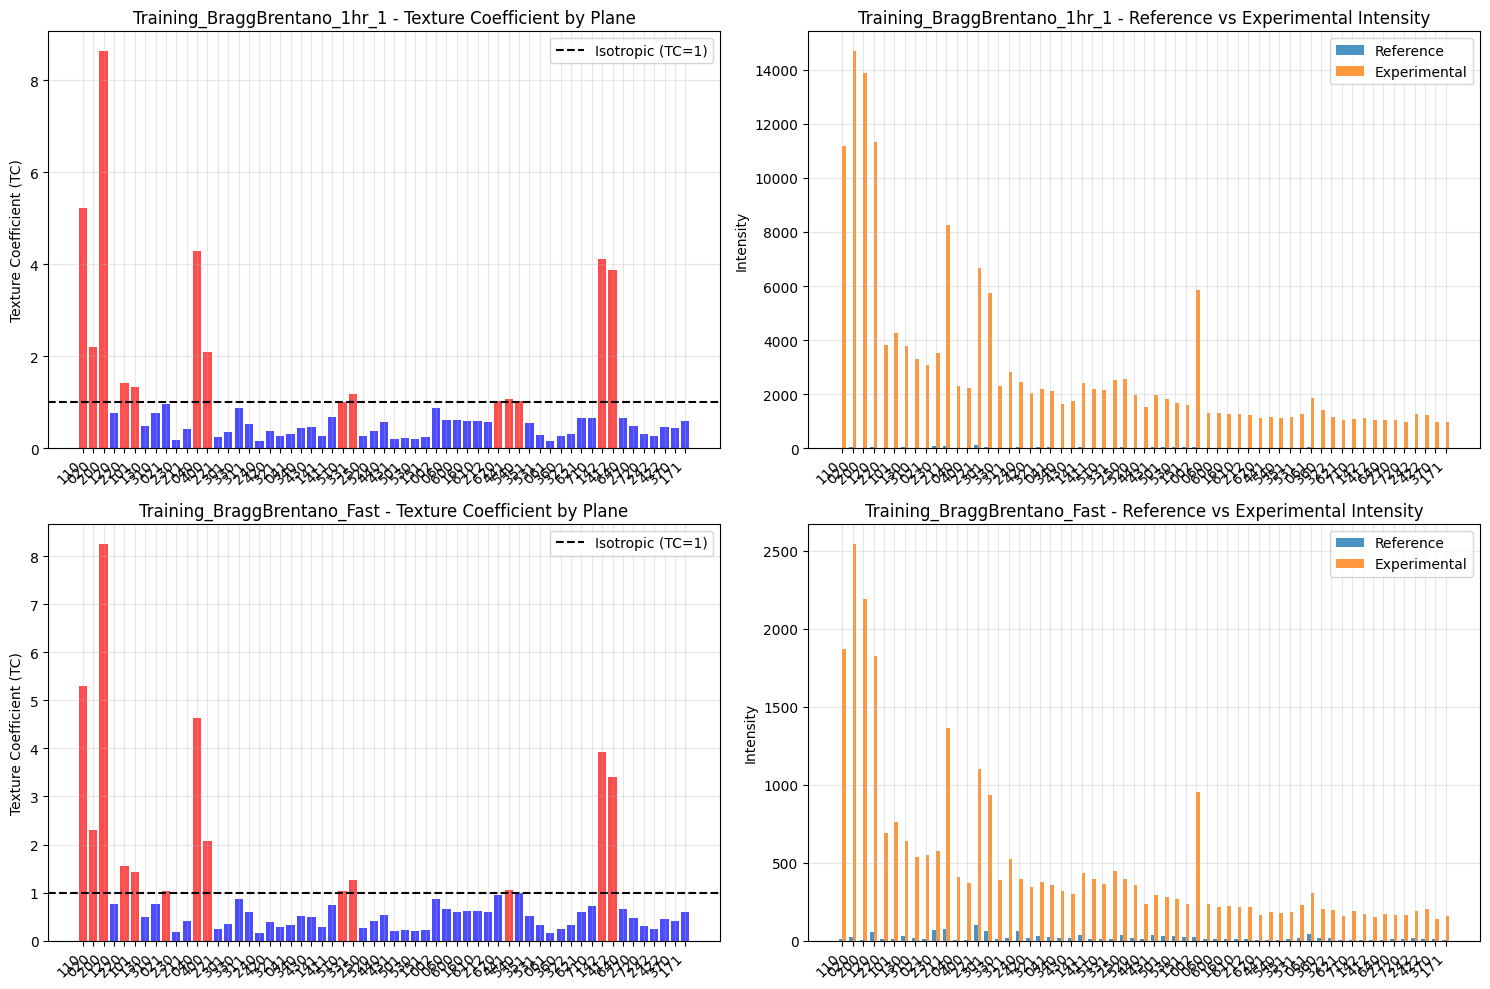

Visualization saved as 'texture_coefficient_analysis.png'


In [34]:
if len(texture_coefficients) == 0:
    print("ERROR: No texture coefficients found!")
    print(f"experimental_data loaded: {len(experimental_data)} datasets")
    print(f"peak_matches found: {len(peak_matches)} datasets")
    
    # Debug: Check what's in experimental_data
    for name, df in experimental_data.items():
        print(f"\n{name}: {len(df)} rows")
        print(df.head())
else:
    fig, axes = plt.subplots(len(texture_coefficients), 2, figsize=(15, 5*len(texture_coefficients)))

    if len(texture_coefficients) == 1:
        axes = axes.reshape(1, -1)

    for idx, (filename, tc_df) in enumerate(texture_coefficients.items()):
        # Plot 1: Texture Coefficient by plane
        ax1 = axes[idx, 0]
        colors = ['red' if tc > 1 else 'blue' for tc in tc_df['TC']]
        ax1.bar(range(len(tc_df)), tc_df['TC'], color=colors, alpha=0.7)
        ax1.axhline(y=1, color='black', linestyle='--', label='Isotropic (TC=1)')
        ax1.set_xticks(range(len(tc_df)))
        ax1.set_xticklabels(tc_df['hkl'], rotation=45, ha='right')
        ax1.set_ylabel('Texture Coefficient (TC)')
        ax1.set_title(f'{filename} - Texture Coefficient by Plane')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Intensity comparison
        ax2 = axes[idx, 1]
        x = np.arange(len(tc_df))
        width = 0.35
        ax2.bar(x - width/2, tc_df['ref_intensity'], width, label='Reference', alpha=0.8)
        ax2.bar(x + width/2, tc_df['exp_intensity'], width, label='Experimental', alpha=0.8)
        ax2.set_xticks(x)
        ax2.set_xticklabels(tc_df['hkl'], rotation=45, ha='right')
        ax2.set_ylabel('Intensity')
        ax2.set_title(f'{filename} - Reference vs Experimental Intensity')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('texture_coefficient_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Visualization saved as 'texture_coefficient_analysis.png'")

## 6. Generate Summary Statistics

Calculate and display comprehensive statistical analysis of texture coefficients, including distribution analysis and key metrics.

In [35]:
# Generate comprehensive summary statistics
print("="*80)
print(" " * 20 + "TEXTURE COEFFICIENT ANALYSIS SUMMARY")
print("="*80)

summary_stats = []

for filename, tc_df in texture_coefficients.items():
    print(f"\n{'Dataset: ' + filename:-^80}")
    print(f"\nReference Database: JCPDS-15-0861")
    print(f"Number of Matched Peaks: {len(tc_df)}")
    print(f"Normalization Factor (R): {normalization_factors[filename]:.4f}")
    
    tc_values = tc_df['TC'].values
    
    print(f"\nTexture Coefficient Statistics:")
    print(f"  Mean TC:           {tc_values.mean():.4f}")
    print(f"  Median TC:         {np.median(tc_values):.4f}")
    print(f"  Standard Dev:      {tc_values.std():.4f}")
    print(f"  Minimum:           {tc_values.min():.4f} ({tc_df.loc[tc_df['TC'].idxmin(), 'hkl']})")
    print(f"  Maximum:           {tc_values.max():.4f} ({tc_df.loc[tc_df['TC'].idxmax(), 'hkl']})")
    print(f"  Variance:          {tc_values.var():.4f}")
    
    # Count preferred and non-preferred orientations
    preferred = (tc_df['TC'] > 1).sum()
    non_preferred = (tc_df['TC'] < 1).sum()
    isotropic = (np.abs(tc_df['TC'] - 1) < 0.01).sum()
    
    print(f"\nPreferred Orientation Analysis:")
    print(f"  Preferred orientations (TC > 1):     {preferred} planes")
    print(f"  Non-preferred orientations (TC < 1): {non_preferred} planes")
    print(f"  Nearly isotropic (|TC-1| < 0.01):   {isotropic} planes")
    
    # Most preferred planes
    top_3 = tc_df.nlargest(3, 'TC')[['hkl', 'TC']]
    print(f"\nTop 3 Preferred Planes:")
    for i, (idx, row) in enumerate(top_3.iterrows(), 1):
        print(f"  {i}. {row['hkl']}: TC = {row['TC']:.4f}")
    
    # Store summary
    summary_stats.append({
        'Dataset': filename,
        'Matched Peaks': len(tc_df),
        'Mean TC': tc_values.mean(),
        'Std Dev': tc_values.std(),
        'Min TC': tc_values.min(),
        'Max TC': tc_values.max(),
        'R Factor': normalization_factors[filename]
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_stats)
print(f"\n{'Summary Table':-^80}")
print(summary_df.to_string(index=False))

# Save results to CSV
for filename, tc_df in texture_coefficients.items():
    output_filename = f"TC_results_{filename}.csv"
    tc_df[['hkl', 'ref_2theta', 'ref_intensity', 'exp_intensity', 'ratio', 'TC']].to_csv(output_filename, index=False)
    print(f"\nResults saved: {output_filename}")

# Save summary
summary_df.to_csv('TC_summary_statistics.csv', index=False)
print("Summary statistics saved: TC_summary_statistics.csv")

                    TEXTURE COEFFICIENT ANALYSIS SUMMARY

---------------------Dataset: Training_BraggBrentano_1hr_1----------------------

Reference Database: JCPDS-15-0861
Number of Matched Peaks: 59
Normalization Factor (R): 267.8574

Texture Coefficient Statistics:
  Mean TC:           1.0000
  Median TC:         0.5656
  Standard Dev:      1.4434
  Minimum:           0.1522 (240)
  Maximum:           8.6290 (200)
  Variance:          2.0834

Preferred Orientation Analysis:
  Preferred orientations (TC > 1):     14 planes
  Non-preferred orientations (TC < 1): 45 planes
  Nearly isotropic (|TC-1| < 0.01):   0 planes

Top 3 Preferred Planes:
  1. 200: TC = 8.6290
  2. 110: TC = 5.2164
  3. 040: TC = 4.2896

----------------------Dataset: Training_BraggBrentano_Fast----------------------

Reference Database: JCPDS-15-0861
Number of Matched Peaks: 59
Normalization Factor (R): 44.1432

Texture Coefficient Statistics:
  Mean TC:           1.0000
  Median TC:         0.5901
  Standard De

## Interpretation Guide

**Understanding Texture Coefficients:**

- **TC = 1.0**: Indicates isotropic crystal distribution (no preferred orientation)
- **TC > 1.0**: Indicates preferred orientation (texture) along that crystallographic plane
- **TC < 1.0**: Indicates suppressed orientation along that plane
- **Mean TC**: Should equal 1.0 if properly normalized. Higher values indicate strong preferred orientation.

**Key Metrics:**
- **R Factor**: The normalization constant; reflects the overall crystallinity
- **Standard Deviation**: Indicates the degree of texture development; higher values = stronger texture
- **Preferred Planes**: Planes with the highest TC values indicate the crystal growth direction